# LGBM을 활용한 베이스라인

In [17]:
import pandas as pd
import os
import random
import numpy as np

## 1. 데이터 로딩

In [18]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!

dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
} 

csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, dtype=dtype, parse_dates=['Timestamp'], infer_datetime_format=True) 

In [19]:
# 선비가 만든 이전 5개 문제 참조하기
df_past = pd.read_csv('past5.csv')
df[['past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']] = df_past[['past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']]
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [20]:
cate = ['testId', 'assessmentItemID', 'KnowledgeTag', 'month', 'hour', 'past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']
non_cate = ['month', 'hour', 'assessment_1', 'assessment_2', 'assessment_3', 'knowledge_clustered', 'user_correct_answer', 'user_total_answer', 'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']#, 'past_OX']

## 2. Feature Engineering

In [23]:
def feature_engineering(df):    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    correct_t.head(5)

    df['month'] = df.Timestamp.dt.month
    df['hour'] = df.Timestamp.dt.hour

    # diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    # diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

    df['assessment_1'] = df.assessmentItemID.apply(lambda  x: int(x[2]))
    df['assessment_2'] = df.assessmentItemID.apply(lambda  x: int(x[4:7]))
    df['assessment_3'] = df.assessmentItemID.apply(lambda  x: int(x[7:]))

    knowledge_clustered = df.loc[:, ['userID', 'KnowledgeTag']].groupby('userID').rolling(window=3, closed='right').std()
    df['knowledge_clustered'] = knowledge_clustered.values
    df['knowledge_clustered'] = df.knowledge_clustered.fillna(method='bfill')
    df['knowledge_clustered'][df.knowledge_clustered > 100] = 100


    # df['past_OX'] = df.loc[:, ['userID', 'answerCode']].groupby('userID').rolling(window=3, closed='left').mean()
    # df['past_OX'] = df.past_OX.fillna(method='bfill')

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    for c in cate:
        df[c] = df[c].astype('category')
    df['Timestamp'] = df.Timestamp.astype('object')
    df = df.drop('Timestamp', axis=1)
    return df

In [24]:
df = feature_engineering(df)
df.head(5)

/tmp/ipykernel_60279/140913174.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['knowledge_clustered'][df.knowledge_clustered > 100] = 100


,userID,assessmentItemID,testId,answerCode,KnowledgeTag,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5,...,month,hour,assessment_1,assessment_2,assessment_3,knowledge_clustered,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,7224,-1,-1,-1,-1,-1,...,3,0,6,1,1,0.57735,0.947683,1268.0,0.955022,637.0
1,0,A060001002,A060000001,1,7225,-1,-1,-1,-1,-1,...,3,0,6,1,2,0.57735,0.947683,1268.0,0.913187,3040.0
2,0,A060001003,A060000001,1,7225,-1,-1,-1,-1,-1,...,3,0,6,1,3,0.57735,0.947683,1268.0,0.913187,3040.0
3,0,A060001004,A060000001,1,7225,-1,-1,-1,-1,-1,...,3,0,6,1,4,0.00000,0.947683,1268.0,0.913187,3040.0
4,0,A060001005,A060000001,1,7225,-1,-1,-1,-1,-1,...,3,0,6,1,5,0.00000,0.947683,1268.0,0.913187,3040.0


## 3. Train/Test 데이터 셋 분리

In [25]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [26]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = cate + non_cate

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [27]:
# !pip install lightgbm

In [28]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [29]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [32]:
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 0 to 2266585
Data columns (total 23 columns):
 #   Column               Dtype   
---  ------               -----   
 0   userID               int16   
 1   assessmentItemID     category
 2   testId               category
 3   answerCode           int8    
 4   KnowledgeTag         category
 5   past_testid_1        category
 6   past_testid_2        category
 7   past_testid_3        category
 8   past_testid_4        category
 9   past_testid_5        category
 10  user_correct_answer  float64 
 11  user_total_answer    int64   
 12  user_acc             float64 
 13  month                category
 14  hour                 category
 15  assessment_1         int64   
 16  assessment_2         int64   
 17  assessment_3         int64   
 18  knowledge_clustered  float64 
 19  test_mean            float64 
 20  test_sum             float64 
 21  tag_mean             float64 
 22  tag_sum              float64 
dtypes: cate

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5,...,month,hour,assessment_1,assessment_2,assessment_3,knowledge_clustered,test_mean,test_sum,tag_mean,tag_sum
1160158,1798,A020101001,A020000101,1,8002,A020000099,A020000097,A020000062,A020000068,A020000060,...,8,12,2,101,1,1.154701,0.731343,980.0,0.779661,3404.0
1376722,2252,A060001005,A060000001,1,7225,A010000061,A020000084,A020000082,A010000048,A020000080,...,5,12,6,1,5,0.000000,0.947683,1268.0,0.913187,3040.0
550536,778,A020055006,A020000055,1,7924,A020000036,A020000035,A020000026,A050000010,A050000011,...,4,23,2,55,6,0.000000,0.730576,1166.0,0.760104,3216.0
214964,289,A080123005,A080000123,1,2714,A080000122,A080000121,A080000119,A080000117,A080000115,...,12,9,8,123,5,1.732051,0.553771,1586.0,0.597765,214.0
647514,926,A020029001,A020000029,1,7914,A020000010,A040000065,A020000028,A020000008,A040000063,...,6,11,2,29,1,0.000097,0.646970,854.0,0.712814,2837.0
393076,538,A060089003,A060000089,0,626,A060000087,A020000006,A060000085,A060000078,A060000076,...,2,9,6,89,3,0.000220,0.441860,665.0,0.483832,1616.0
1027277,1539,A070042003,A070000042,1,1257,A030000030,A030000023,A030000021,A030000019,A030000005,...,4,1,7,42,3,100.000000,0.533923,724.0,0.471364,1037.0
888575,1306,A050043002,A050000043,0,3704,A050000042,A050000041,A050000034,A050000033,A050000032,...,4,2,5,43,2,0.577350,0.482667,543.0,0.649378,2767.0
1063261,1607,A060096006,A060000096,1,628,A050000059,A060000093,A060000094,A090000025,A060000090,...,7,14,6,96,6,0.577350,0.488304,1002.0,0.457016,925.0
1624265,2844,A040037003,A040000037,0,2067,A040000033,A040000021,A040000015,A040000013,A040000005,...,4,10,4,37,3,0.000106,0.626415,830.0,0.632151,2674.0


## 4. 훈련 및 검증

In [31]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/envs/venv2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/venv2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


AttributeError: 'DataFrame' object has no attribute 'cat'

## 5. Inference

In [ ]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'], infer_datetime_format=True)

In [ ]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv


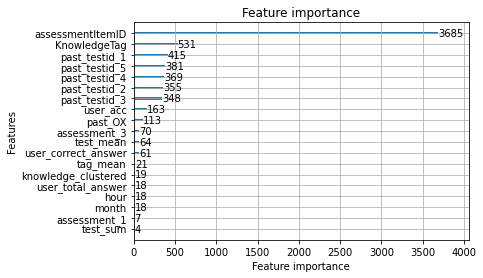

In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
image = lgb.plot_importance(model)

## wandb 로그

In [ ]:
import wandb
wandb.init()
wandb.log({"examples": [wandb.Image(image, caption="Label")]})
# or
# example_images.append(wandb.Image(
#                 data[0], caption="Pred: {} Truth: {}".format(pred[0].item(), target[0])))
# wandb.log({"Examples": example_images})